# Data Processing

## Explore data

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold,cross_val_predict
from sklearn.metrics import accuracy_score, f1_score,precision_score,mean_squared_error, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier

In [2]:
# import data 
train = pd.read_csv('/kaggle/input/simulates-real-world-agricultural-data/train.csv')
test = pd.read_csv('/kaggle/input/simulates-real-world-agricultural-data/test.csv')
# Display the first few rows of the dataset
train.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [3]:
# check any null value
print(train.isnull().sum())

id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64


In [4]:
# Print the data information
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB
None


There are 10 columns with 750000 rows, without any null values. 'Soli Type', 'Crop Type' and 'Fertilizer Name' are catogory type, others are numeric type.

In [5]:
# Print statistics
print(train.describe())

                  id    Temparature       Humidity       Moisture  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      31.503565      61.038912      45.184147   
std    216506.495284       4.025574       6.647695      11.794594   
min         0.000000      25.000000      50.000000      25.000000   
25%    187499.750000      28.000000      55.000000      35.000000   
50%    374999.500000      32.000000      61.000000      45.000000   
75%    562499.250000      35.000000      67.000000      55.000000   
max    749999.000000      38.000000      72.000000      65.000000   

            Nitrogen      Potassium    Phosphorous  
count  750000.000000  750000.000000  750000.000000  
mean       23.093808       9.478296      21.073227  
std        11.216125       5.765622      12.346831  
min         4.000000       0.000000       0.000000  
25%        13.000000       4.000000      10.000000  
50%        23.000000       9.000000      21.000000  
75%    

Base on the describe, the data range is resonable,so no normalization needed.

# Data Preprocessing

### Encode Categorical Variables

In [6]:
le_soil = LabelEncoder()
le_crop = LabelEncoder()
le_fert = LabelEncoder()

train['Soil Type'] = le_soil.fit_transform(train['Soil Type'])
train['Crop Type'] = le_crop.fit_transform(train['Crop Type'])
train['Fertilizer Name'] = le_fert.fit_transform(train['Fertilizer Name'])

In [7]:
# Define features and target
X = train.drop(columns=['id', 'Fertilizer Name'])
y = train['Fertilizer Name']

### Check data balance

<Axes: xlabel='Fertilizer Name'>

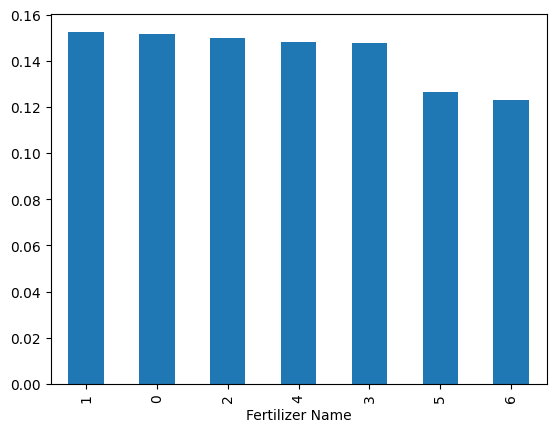

In [8]:
train['Fertilizer Name'].value_counts(normalize=True).plot(kind='bar')

The class distribution for the target variable 'Fertilizer Name' is fairly balanced.

# Model Training

In [9]:
def evaluate_metrics(y_true, y_pred):
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("F1-score:", round(f1_score(y_true, y_pred, average="weighted"), 4))
    print("Precision:", round(precision_score(y_true, y_pred, average="weighted"), 4))
    print("Recall (Sensitivity):", round(recall_score(y_true, y_pred, average="weighted"), 4))
    print("Mean Squared Error:", round(mean_squared_error(y_true, y_pred), 4))
    print("\nClassification Report:")
    print(classification_report(y, y_pred, zero_division=0))

In [10]:
# Use cross-validation-friendly split for balanced classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Model 1: Logistic Regression

In [11]:
# Scale + LogisticRegression wrapped in OneVsRest
base_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
#  RFECV (Recursive Feature Elimination + CV)
rfecv = RFECV(
    estimator=base_model,
    step=1,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

#  Scale features before RFECV (to avoid leakage)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Fit RFECV to select features
rfecv.fit(X_scaled, y)
selected_features = X.columns[rfecv.support_]
print(f"✅ Optimal number of features: {rfecv.n_features_}")
print(f"✅ Selected features: {selected_features.tolist()}")

✅ Optimal number of features: 8
✅ Selected features: ['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous']


In [12]:
pipe = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
)

y_pred = cross_val_predict(pipe, X[selected_features], y, cv=cv)

evaluate_metrics(y, y_pred)

Accuracy: 0.1572
F1-score: 0.1274


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.1176
Recall (Sensitivity): 0.1572
Mean Squared Error: 7.3599

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.28      0.20    113887
           1       0.16      0.31      0.21    114436
           2       0.16      0.18      0.17    112453
           3       0.15      0.06      0.09    110889
           4       0.15      0.20      0.17    111158
           5       0.00      0.00      0.00     94860
           6       0.00      0.00      0.00     92317

    accuracy                           0.16    750000
   macro avg       0.11      0.15      0.12    750000
weighted avg       0.12      0.16      0.13    750000



### Model 2: Random Forest

In [13]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf_preds = cross_val_predict(rf_model, X, y, cv=cv)
evaluate_metrics(y, rf_preds)

Accuracy: 0.1773
F1-score: 0.1543
Precision: 0.1837
Recall (Sensitivity): 0.1773
Mean Squared Error: 6.9608

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.26      0.21    113887
           1       0.18      0.34      0.23    114436
           2       0.19      0.21      0.20    112453
           3       0.18      0.13      0.15    110889
           4       0.17      0.21      0.19    111158
           5       0.20      0.03      0.05     94860
           6       0.21      0.01      0.01     92317

    accuracy                           0.18    750000
   macro avg       0.18      0.17      0.15    750000
weighted avg       0.18      0.18      0.15    750000



### Model 3: XGBoost Model

In [14]:
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_preds = cross_val_predict(xgb_model, X, y, cv=cv)
evaluate_metrics(y, xgb_preds)

Accuracy: 0.1921
F1-score: 0.1856
Precision: 0.1922
Recall (Sensitivity): 0.1921
Mean Squared Error: 6.7429

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.23      0.21    113887
           1       0.19      0.26      0.22    114436
           2       0.20      0.23      0.21    112453
           3       0.19      0.19      0.19    110889
           4       0.19      0.21      0.20    111158
           5       0.20      0.11      0.14     94860
           6       0.19      0.07      0.10     92317

    accuracy                           0.19    750000
   macro avg       0.19      0.19      0.18    750000
weighted avg       0.19      0.19      0.19    750000



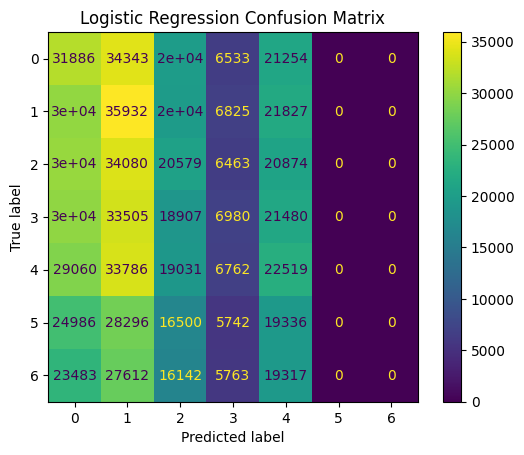

In [15]:
# Logistic Regression
ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

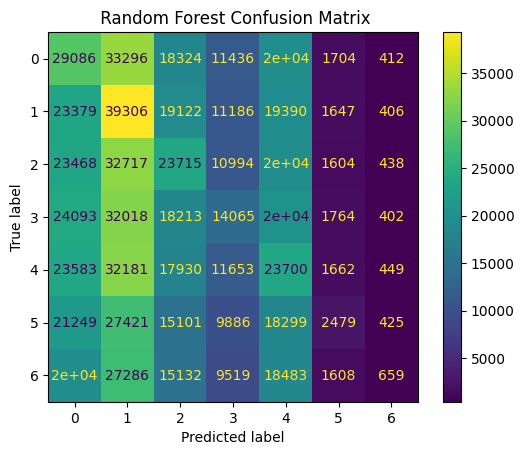

In [16]:
# Random Forest 
ConfusionMatrixDisplay.from_predictions(y, rf_preds)
plt.title(" Random Forest Confusion Matrix")
plt.show()

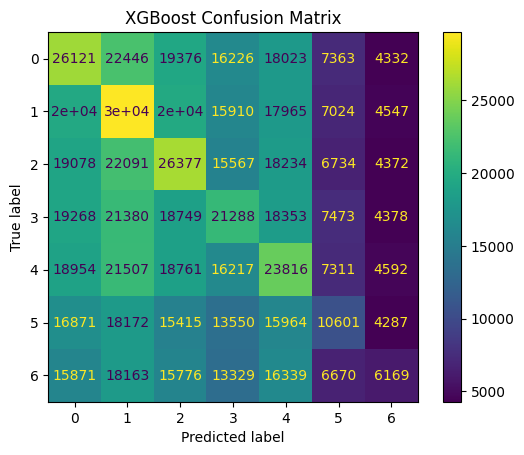

In [17]:
# XGBoost
ConfusionMatrixDisplay.from_predictions(y, xgb_preds)
plt.title("XGBoost Confusion Matrix")
plt.show()